# Spencer Hallyburton
## Homework #4
## Collaborator: Salvador Barragan
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import time
from tqdm import tnrange, tqdm_notebook
import time
import math
from functools import partial
import random
from tqdm import tnrange, tqdm_notebook

start_time = time.time()
%matplotlib inline

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each iteration, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [17]:
my_data = np.genfromtxt('HW3_data.csv', delimiter=',')
print('Data Shape:', my_data.shape)

Data Shape: (2, 16000)


In [49]:
# Set up functions
from mpl_toolkits.mplot3d import Axes3D

def loss(X, Y, LAMBDA):
    T1 =  .000045*LAMBDA[1]**2 * Y 
    T2 = -.000098*LAMBDA[0]**2 * X
    T3 =  .003926*LAMBDA[0] * X * np.exp( (Y**2 - X**2) * (LAMBDA[0]**2 + LAMBDA[1]**2) )
    return np.sum(T1 + T2 + T3)

def make_3d_plot(xfinal, yfinal, zfinal, history, loss, X, Y):
    L1s = np.linspace(xfinal - 10 , xfinal + 10, 40)
    L2s = np.linspace(yfinal - 10 , yfinal + 10, 40)
    L1, L2 = np.meshgrid(L1s, L1s)
    zs = np.array([loss(X, Y, LAMBDA) 
                   for LAMBDA in zip(np.ravel(L1), np.ravel(L2))])
    Z = zs.reshape(L1.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    off = -10
    ax.plot_surface(L1, L2, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(L1, L2, Z, 20, alpha=0.5, offset=off, stride=30)
    ax.set_xlabel('Lambda 1')
    ax.set_ylabel('Lambda 2')
    ax.set_zlabel('Loss Function')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in history], [t[1] for t in history], loss , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in history], [t[1] for t in history], off , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    plt.show()
    
def sa_plot(X, Y, LAMBDA, loss, history):
    if not isinstance(loss, list):
        loss = [loss]
    make_3d_plot(LAMBDA[0], LAMBDA[1], loss[-1], history, loss, X, Y)
    

In [47]:
# Proposal Function:
covNorm = np.array([[1,0],[0,1]])
pfxs = lambda mean: np.random.multivariate_normal(mean, covNorm)
print('Example:', pfxs([0,2]))

Example: [ 0.50106713  1.93962852]


In [20]:
# Temperature and iterations
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

In [21]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc, opt_cond='Dist'):
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    for index in range(epochs):
        print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        print("Temperature", T, "Length", length)
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

In [22]:
loss_lam = partial(loss,my_data[0,:], my_data[1,:])
inits=dict(solution=[-5,0], length=100, T=100)
# Run the SA algorithm
bmeta, bs, be, out = sa(loss_lam, inits, 30, tf, itf, pfxs)

Epoch 0
Temperature 100 Length 100
Epoch 1
Temperature 80.0 Length 120
Epoch 2
Temperature 64.0 Length 144
Epoch 3
Temperature 51.2 Length 173
Epoch 4
Temperature 40.96000000000001 Length 208
Epoch 5
Temperature 32.76800000000001 Length 250
Epoch 6
Temperature 26.21440000000001 Length 300
Epoch 7
Temperature 20.97152000000001 Length 360
Epoch 8
Temperature 16.777216000000006 Length 432
Epoch 9
Temperature 13.421772800000006 Length 519
Epoch 10
Temperature 10.737418240000006 Length 623
Epoch 11
Temperature 8.589934592000004 Length 748
Epoch 12
Temperature 6.871947673600004 Length 898
Epoch 13
Temperature 5.497558138880003 Length 1078
Epoch 14
Temperature 4.398046511104003 Length 1294
Epoch 15
Temperature 3.5184372088832023 Length 1553
Epoch 16
Temperature 2.814749767106562 Length 1864
Epoch 17
Temperature 2.25179981368525 Length 2237
Epoch 18
Temperature 1.8014398509482001 Length 2685
Epoch 19
Temperature 1.4411518807585602 Length 3222
Epoch 20
Temperature 1.1529215046068482 Length 3867

In [23]:
# Print out results:
print('Global Minimum Suggestion:',bs,'\nWith Loss Function:', be)

Global Minimum Suggestion: [ 2.05394228  0.00724575] 
With Loss Function: -9.93403693934


### Now, plot the process

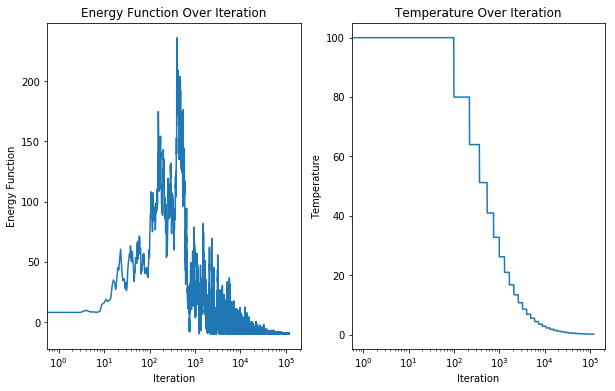

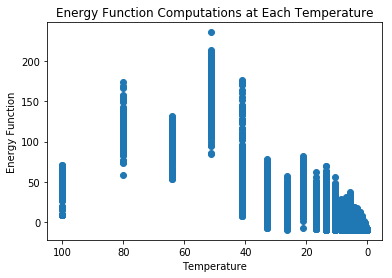

In [68]:
# Create plots of the energy (cost) and the temperature over iterations
accum_list = list(zip(*out))
T = accum_list[0]
LAM = accum_list[1]
E = accum_list[2]

fig, ax = plt.subplots(1,2,figsize=(10,6))

# Plotting energy function
ax[0].plot(E)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Energy Function')
ax[0].set_xscale('log')
ax[0].set_title('Energy Function Over Iteration')
# Plotting temperature
ax[1].plot(T)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Temperature')
ax[1].set_title('Temperature Over Iteration')
ax[1].set_xscale('log')
plt.show()


# Plotting temperature
plt.scatter(T,E)
plt.xlabel('Temperature')
plt.ylabel('Energy Function')
plt.title('Energy Function Computations at Each Temperature')
plt.gca().invert_xaxis()
plt.show()

### Compare to Gradient Descent and SGD:
When we compare this implementation to GD and SGD, we notice a few things. First, we see that the suggested global minimum is indeed the global minimum. This beats the attempts made by GD and SGD to compute minima, as they both got stuck in local minima. Second, one of the requirements of an annealing algorithm is that we have to be able to access all of the locations on our parameter space. This is similar to trio of aperiodicity, irreducibility, and recurrence that we demanded in Markov Chain construction. In order to ensure that we have reached the global minimum, we must meet the condition that we have to be able to access all of these locations.

## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range [1, 50). Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for 
$N=100$, optimizing the travel path for the total distance travelled (but keeping track 
of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the exisitence of a flight between two cities are altered?


In [7]:
# Functions to get the permutations of the tours
def alltours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

# Gets the first city of a collection
def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

Tour = list  # Tours are implemented as lists of cities

# Function to get the length of the tour
def tour_length(threshD, threshP, tour):
    "The total of distances between each pair of consecutive cities in the tour."
    tour_dist=0
    tour_time=0
    for i in range(len(tour)):
        tour_dist_new, tour_time_new = distance(tour[i], tour[i-1], threshD, threshP)
        tour_dist+=tour_dist_new
        tour_time+=tour_time_new
        
    return {'Dist':tour_dist, 'Time':tour_time}

In [8]:
# Cities are represented as Points, which are a subclass of complex numbers
from collections import namedtuple

# City is a named tuple with x and y position and a population
City = namedtuple('City', ['x', 'y', 'pop'], verbose=False)

In [9]:
# Get the distance between two cities
def distance(A, B, threshD, threshP): # Note: we have modified this function to reflect the complexity of the problem
    "The distance between two cites."
    euc_dist = math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))
    # Convert distance to a time
    if (euc_dist > threshD) & (A.pop > threshP) & (B.pop > threshP):
        time = euc_dist / 10
    else:
        time = euc_dist
    return(euc_dist, time)

def Cities(n, width=900, height=600, popmax=10, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(City(random.randrange(1,width), random.randrange(1,height), popmax*random.random())
                     for c in range(n))

def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], 'rs') # Mark the start city with a red square
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.axis('scaled'); plt.axis('off')
    
def plot_tsp(algorithm, cities, threshD, threshP):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    tour_length_partial = partial(tour_length, threshD, threshP)
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} and time {:.3f}s"
          .format(len(tour), tour_length_partial(tour)['Dist'],tour_length_partial(tour)['Time']))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

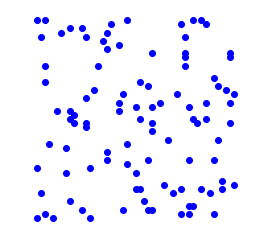

In [10]:
# Create list of cities
mycities = Cities(100, seed=332, width=50, height=50, popmax=10)
plot_lines(mycities, 'bo')

In [11]:
def change_tour(input_tour):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_tour))
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_tour, c1, c2)
    
    return new_tour

def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save city1
    city1 = input_tour[i]
    
    # save city2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour
    
change_path = swap_cities  

In [12]:
def plot_optimization(out):
    # Plot the results of the optimization routine
    fig = plt.figure()
    ax = fig.add_subplot(111)

    lns1 = ax.plot(range(len(out)),[e[2]['Dist'] for e in out], alpha=0.6, lw=2, color='b', label='Dist')
    ax2 = ax.twinx()
    lns2 = ax2.plot(range(len(out)),[e[2]['Time'] for e in out], alpha=0.6, lw=2, color='r', label='Time')

    # added these two lines
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

    # Plot result
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Trip Distance')
    ax2.set_ylabel('Trip Time')
    plt.xscale('log')
    plt.show()

In [13]:
def sa_tsp(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc, OC='Dist'):
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    
    # Reannealing
    ANN_INT = 100
    beta = 1.5
    
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    i = 0
    for index in tnrange(epochs):
        i+=1
        if i % ANN_INT == 0: # Reannealing
            T = initials['T'] * (1 - index/epochs)
            length = initials['length']
            ANN_INT = np.ceil(beta*ANN_INT)
            i = 0
            print('Epoch=%d, Reannealing...' % index)

        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy[OC] - new_energy[OC])/T))
            if ((new_energy[OC] < old_energy[OC]) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if new_energy[OC] < best_energy[OC]:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("RESULTS:\nFrac accepted: %.4f\nTotal Iterations: %d\nBest Meta - Index=%d, Temp=%.4e" %
          (accepted/total, total, best_meta['index'], best_meta['temp']))
    return best_meta, best_solution, best_energy, accumulator

In [14]:
# Initialize functions
initial_tour = list(mycities)
length_func1 = lambda temperature: np.max((np.floor(np.sqrt(temperature)).astype(int),1))
length_func2 = lambda length: min(int(math.ceil(1.2*length)), 100)
length_func = length_func2
temp_func = lambda t: 0.94*t

# Initialize state
init_length = length_func(10)
inits=dict(solution=initial_tour, length=init_length, T=50.0)

### Optimizing for Tour Distance:

In [15]:
# Run annealing algorithm
threshD = 10
threshP = 5
tour_length_partial = partial(tour_length, threshD, threshP)
opt_cond = 'Dist'
t0 = time.clock()
bmeta, bs, be, out = sa_tsp(tour_length_partial, inits, 2000, temp_func, length_func, change_tour);
t1 = time.clock()
print('Algorithm Time:', t1-t0)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Epoch=99, Reannealing...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Epoch=249, Reannealing...
Epoch=474, Reannealing...
Epoch=812, Reannealing...
Epoch=1319, Reannealing...

RESULTS:
Frac accepted: 0.0390
Total Iterations: 196402
Best Meta - Index=161356, Temp=2.1697e-08
Algorithm Time: 43.386523000000004


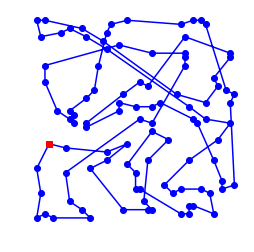

100 city tour with length 605.6 and time 575.252s


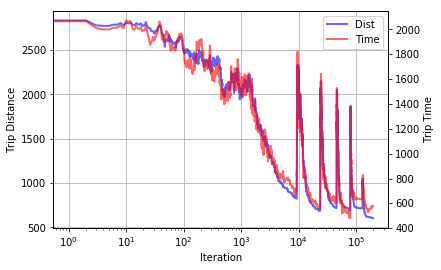

In [277]:
plot_tsp(lambda x: bs, mycities, threshD, threshP)
plot_optimization(out)

### Optimizing for Tour Time:

In [315]:
# Run annealing algorithm
threshD = 10
threshP = 5
tour_length_partial = partial(tour_length, threshD, threshP)
opt_cond = 'Time'
t0 = time.clock()
bmeta, bs, be, out = sa_tsp(tour_length_partial, inits, 2000, temp_func, length_func, change_tour);
t1 = time.clock()
print('Algorithm Time:', t1-t0)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


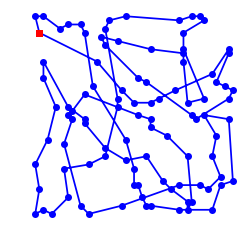

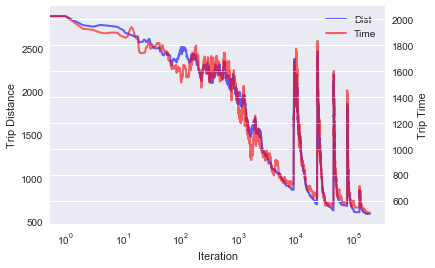

In [316]:
plot_tsp(lambda x: bs, mycities, threshD, threshP)
plot_optimization(out)

After performing the annealing algorithm to optimize tour time and tour distance, we see that the results are quite similar. In this particular iteration, we see that performing the optimization for distance led to a lower distance and a higher time when compared to the optimization for time. This may not always be true, given the stochasticity of simulated annealing, however, this trend is to be expected given the conditions of the algorithm.

### Trying different threshold conditions

In [309]:
threshD = [5, 10, 15]
threshP = [3, 5, 7]
Dmesh, Pmesh = np.meshgrid(threshD, threshP)
be_all_dist = np.zeros(np.shape(Dmesh))

In [313]:
# Run annealing algorithm over a grid of parameters optimizing for distance
import sys
import os
old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")

for i, threshDval in enumerate(threshD):
    for j, threshPval in enumerate(threshP):
        tour_length_partial = partial(tour_length, threshDval, threshPval)
        opt_cond = 'Dist'
        t0 = time.clock()
        bmeta, bs, be, out = sa_tsp(tour_length_partial, inits, 1000, temp_func, length_func, change_tour);
        be_all_dist[i,j] = be[opt_cond]
        t1 = time.clock()
        
# Return to standard output
sys.stdout = old_stdout

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

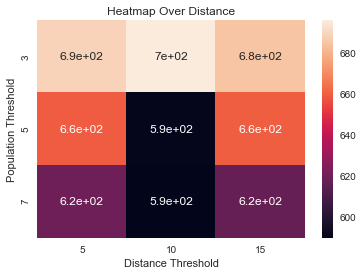

In [314]:
import seaborn as sns; sns.set()
ax = sns.heatmap(be_all_dist,annot=True, xticklabels=threshD, yticklabels=threshP)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Population Threshold')
ax.set_title('Heatmap Over Distance')
plt.show()